# Step 5 : residuals of SDC sweeps

📜 _Once we have defined our SDC method after choosing :_

- _some_ $Q$_-coefficients (underlying time-stepping method, cf. [step 1](./01_qCoeffs.ipynb)),_
- _one_ $Q_\Delta$ _approximation (preconditioner for SDC, cf. [step 3](./01_qCoeffs.ipynb)),_

_we need to evaluate the quality of this new time-integration method._ 
_For that, we can have a look at the **residuals**._


Starting from the SDC sweep formula

$$
u^{k+1} - \lambda\Delta{t}Q_\Delta u^{k+1} = u_n + \lambda\Delta{t}(Q-Q_\Delta)u^k,
$$

the residual at sweep $k$ for the Dahlquist problem is defined as :

$$
r^k = u_n - A u^{k} = u_n + \lambda\Delta{t}Q u^k - u^k.
$$

From an implementation perspective, it can be interpreted as the 
**difference of the SDC solution versus the solution obtained with the underlying time-integration method**
defined by the $Q$-coefficients.

For instance, if the $Q$-coefficients are obtained using a collocation method, 
then the numerical solution at node $u_m := u(t_0 + \tau_m\Delta{t})$ should satisfy :

$$
u_m = u_0 + \int_{t_0}^{t_m} \lambda u(s)ds,
$$

where the integral is approximated with the quadrature rule stored in the $Q$ matrix. 
Hence if we note $u^C$ the collocation solution, then we have

$$
u^C = u_n + \lambda\Delta{t}Q u^C,
$$

which means that the SDC residuals for this solution are zeros.

> ⚠️ **Residuals** and **time-integration errors** are not the same, 
> since the underlying method for SDC has its own time discretization error, 
> even if the underlying method is usually chosen to be very accurate.

Let's setup (as before) the Dahlquist problem ...

In [1]:
import numpy as np

# Problem settings
lam = 1j
T = 4*np.pi
u0 = np.exp(1j*np.pi/6)

nSteps = 12
dt = T/nSteps
times = np.linspace(0, T, nSteps+1)

... and the definition of our SDC method :

In [2]:
from qmat import Q_GENERATORS, genQDeltaCoeffs

coll = Q_GENERATORS["coll"](nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")
nodes, weights, Q = coll.genCoeffs()

QDelta = genQDeltaCoeffs("BE", nodes=nodes, coll=coll, Q=Q)
P = np.eye(nodes.size) - lam*dt*QDelta

We build our SDC loop, and this time store the residuals for each sweeps, time-steps and nodes, 
along with the numerical error versus the analytical solution :

In [3]:
nSweeps = 4
uNum = np.zeros(nSteps+1, dtype=complex)
residuals = np.zeros((nSweeps+1, nSteps, nodes.size), dtype=complex)
error = np.zeros((nSweeps+1, nSteps, nodes.size), dtype=complex)

uNum[0] = u0
for i in range(nSteps):

    uNodes = np.ones(nodes.size)*uNum[i]  # initial guess
    
    # Initial residuals & error
    residuals[0, i] = uNum[i] + lam*dt*Q @ uNodes - uNodes
    error[0, i] = uNodes - u0*np.exp(lam*(times[i] + dt*nodes))

    # Sweeps
    for k in range(nSweeps):
        b = uNum[i] + lam*dt*(Q-QDelta) @ uNodes
        uNodes = np.linalg.solve(P, b)

        # Residual & error after sweep
        residuals[k+1, i] = uNum[i] + lam*dt*Q @ uNodes - uNodes
        error[k+1, i] = uNodes - u0*np.exp(lam*(times[i] + dt*nodes))
        
    uNum[i+1] = uNum[i] + lam*dt*weights.dot(uNodes)  # prolongation

Finally, we take the $L_\infty$ norm on each nodes ...

In [4]:
residuals = np.linalg.norm(residuals, axis=-1, ord=np.inf)
error = np.linalg.norm(error, axis=-1, ord=np.inf)

... and plot this versus time for each sweeps :

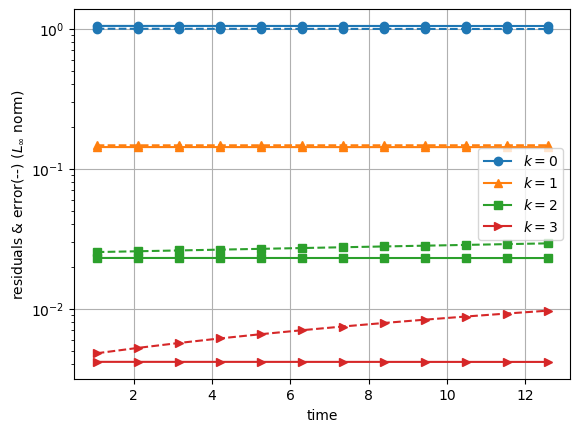

In [5]:
import matplotlib.pyplot as plt

for k, sym in zip(range(nSweeps+1), ["o", "^", "s", ">"]):
    p = plt.semilogy(times[1:], residuals[k], sym+'-', label=f"$k={k}$")
    plt.semilogy(times[1:], error[k], sym+'--', c=p[0].get_color())
plt.grid(); plt.xlabel("time"); plt.ylabel(r"residuals & error(--) ($L_\infty$ norm)"); plt.legend();


We see that residuals are a good approximation of the numerical error for the first sweeps,
but we also see some discrepancies for the last sweeps.
While the residuals are relatively constant over time, the time-discretization error increases for the last sweeps,
which is not shown by the residuals.

This is because we only did 4 SDC sweeps here, so the SDC approach is way less accurate than the underlying collocation
method using 4 Legendre Radau-Right nodes (order 7).
This can be observed more in details by looking at different total numbers of sweeps $K$. 
For that, we can use the `monitor` parameter of the `solveDahlquistSDC` function (simplifies the code), 
extract the maximum $L_\infty$ norm over all time-steps,
and plot this versus the sweeps :

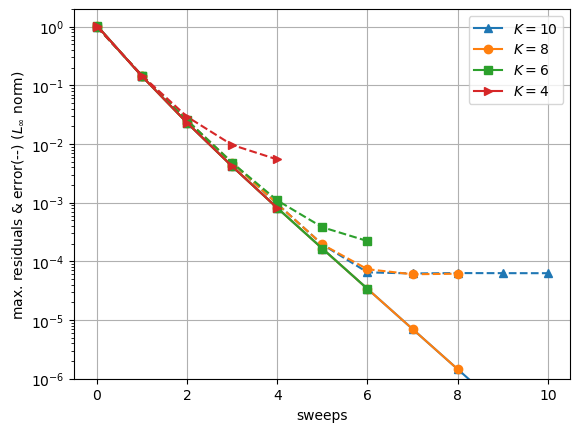

In [6]:
from qmat.sdc import solveDahlquistSDC

for nSweeps, sym in zip([10, 8, 6, 4], ["^", "o", "s", ">"]):

    uNum, monitors = solveDahlquistSDC(
        lam=lam, u0=u0, T=T, nSteps=nSteps, nSweeps=nSweeps,
        Q=Q, QDelta=QDelta, weights=weights, 
        monitors=["residuals", "errors"]  # list of data we want to monitor for all nodes, time-steps and sweeps
    ) 

    # Extract maximum residuals and errors over time
    residuals = np.max(np.linalg.norm(monitors["residuals"], axis=-1, ord=np.inf), axis=-1)
    errors = np.max(np.linalg.norm(monitors["errors"], axis=-1, ord=np.inf), axis=-1)

    p = plt.semilogy(residuals, sym+'-', label=f"$K={nSweeps}$")
    plt.semilogy(errors, sym+'--', c=p[0].get_color())

plt.grid(); plt.xlabel("sweeps"); plt.ylabel(r"max. residuals & error(--) ($L_\infty$ norm)")
plt.ylim(1e-6, 2); plt.legend();


Here 8 sweeps are required to reach an accuracy below $1e^{-4}$, which is the accuracy of the collocation method.
While the residuals decrease is almost identical when $K$ varies, this is not the same for the errors, 
that follows the residuals decrease only when $K$ is large enough.

> 💡 If the time-discretization error of the underlying method is known a priori, then targeting a 
> **residual level close to the time-discretization error level** can be an acceptable stopping criterion.

In practice, residuals can be also monitored to evaluate the quality of a $Q_\Delta$ approximation. 
For instance, if we use the same SDC method, but using a trapezoidal rule for $Q_\Delta$, 
and monitor residuals & errors ... 

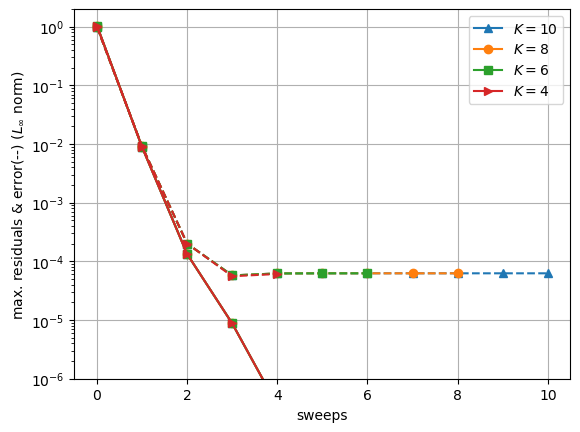

In [7]:
QDelta = genQDeltaCoeffs("TRAP", nodes=nodes, coll=coll, Q=Q)

for nSweeps, sym in zip([10, 8, 6, 4], ["^", "o", "s", ">"]):

    uNum, monitors = solveDahlquistSDC(
        lam=lam, u0=u0, T=T, nSteps=nSteps, nSweeps=nSweeps,
        Q=Q, QDelta=QDelta, weights=weights, monitors=["residuals", "errors"])

    residuals = np.max(np.linalg.norm(monitors["residuals"], axis=-1, ord=np.inf), axis=-1)
    errors = np.max(np.linalg.norm(monitors["errors"], axis=-1, ord=np.inf), axis=-1)

    p = plt.semilogy(residuals, sym+'-', label=f"$K={nSweeps}$")
    plt.semilogy(errors, sym+'--', c=p[0].get_color())

plt.grid(); plt.xlabel("sweeps"); plt.ylabel(r"max. residuals & error(--) ($L_\infty$ norm)"); 
plt.ylim(1e-6, 2); plt.legend();


... we can see that with this preconditioner, the SDC iteration converges **way faster to the collocation accuracy** (only two sweeps), and this is visible in some residuals value that decrease very quickly.

Comparing the residuals evolution for different types of approximations can then give some first insights on the efficiency of different SDC variants, for instance when we compare the Backward-Euler sweep from the original SDC methods,
the Trapezoidal rule and the `MIN-SR-NS` diagonal approximation from [[Caklovic et al., 2024]](https://arxiv.org/pdf/2403.18641>) :

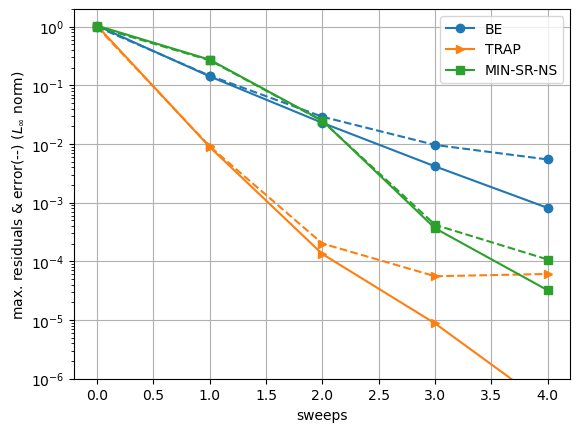

In [8]:
nSweeps = 4
for qDelta, sym in zip(["BE", "TRAP", "MIN-SR-NS"], ["o", ">", "s"]):

    QDelta = genQDeltaCoeffs(qDelta, nodes=nodes, coll=coll, Q=Q)

    uNum, monitors = solveDahlquistSDC(
        lam=lam, u0=u0, T=T, nSteps=nSteps, nSweeps=nSweeps,
        Q=Q, QDelta=QDelta, weights=weights, monitors=["residuals", "errors"])

    residuals = np.max(np.linalg.norm(monitors["residuals"], axis=-1, ord=np.inf), axis=-1)
    errors = np.max(np.linalg.norm(monitors["errors"], axis=-1, ord=np.inf), axis=-1)

    p = plt.semilogy(residuals, sym+'-', label=f"{qDelta}")
    plt.semilogy(errors, sym+'--', c=p[0].get_color())

plt.grid(); plt.xlabel("sweeps"); plt.ylabel(r"max. residuals & error(--) ($L_\infty$ norm)"); 
plt.ylim(1e-6, 2); plt.legend();

Here the `MIN-SR-NS` coefficients require $K=4$ sweeps to reach the collocation accuracy, 
which is better than the `BE`-based sweep, but still twice larger as the `TRAP`-based SDC.

However, measuring the number of iterations to a given accuracy is **not sufficient** to assess the efficiency of
a SDC variant. Here for instance, since the `MIN-SR-S` approximation is diagonal, this enable some parallelism across
the sweep update that can improve the time-to-solution.

Also, we looked at convergence only for one $\lambda$ value, and only considered the accuracy. 
While this is interesting for a first look, analyzing other numerical aspects of SDC variants is critical
for a fair comparison. 
This is especially true for numerical stability, which is the subject of the next tutorial (incoming ...)